/tmp/ipykernel_35750/1627151222.py:30: RuntimeWarning: overflow encountered in exp
  sum = sum + ((p_values[count] - (x_1 * psat1 * np.exp(a_12 * ((a_21*x_2/inside_denom) ** 2))) - (x_2 * psat2 * np.exp(a_21 * ((a_12*x_1/inside_denom) ** 2)))) ** 2)
/tmp/ipykernel_35750/1627151222.py:30: RuntimeWarning: overflow encountered in double_scalars
  sum = sum + ((p_values[count] - (x_1 * psat1 * np.exp(a_12 * ((a_21*x_2/inside_denom) ** 2))) - (x_2 * psat2 * np.exp(a_21 * ((a_12*x_1/inside_denom) ** 2)))) ** 2)
/tmp/ipykernel_35750/1627151222.py:30: RuntimeWarning: overflow encountered in exp
  sum = sum + ((p_values[count] - (x_1 * psat1 * np.exp(a_12 * ((a_21*x_2/inside_denom) ** 2))) - (x_2 * psat2 * np.exp(a_21 * ((a_12*x_1/inside_denom) ** 2)))) ** 2)
/tmp/ipykernel_35750/1627151222.py:30: RuntimeWarning: overflow encountered in exp
  sum = sum + ((p_values[count] - (x_1 * psat1 * np.exp(a_12 * ((a_21*x_2/inside_denom) ** 2))) - (x_2 * psat2 * np.exp(a_21 * ((a_12*x_1/inside_denom) ** 2

0.9990897602351617


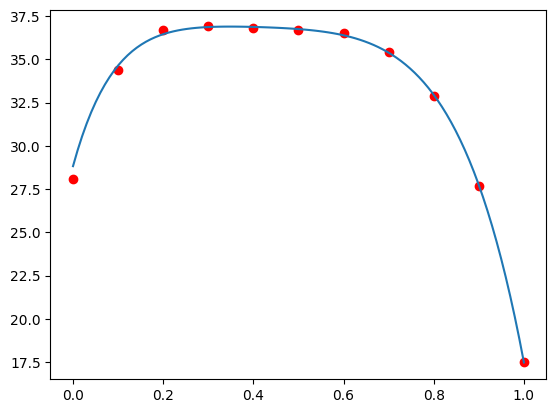

In [110]:

import numpy as np
import numdifftools as nd
import matplotlib.pyplot as plt

x_1_values = np.arange(0,1.1,0.1)
p_values = [28.1, 34.4, 36.7, 36.9, 36.8, 36.7, 36.5, 35.4, 32.9, 27.7, 17.5]

a_1_w = 8.07131
a_2_w = 1730.63
a_3_w = 233.426

a_1_d = 7.43155
a_2_d = 1554.679
a_3_d = 240.337

T = 20

psat1 = 10 ** (a_1_w - (a_2_w/(T + a_3_w)))
psat2 = 10 ** (a_1_d - (a_2_d/(T + a_3_d)))

def f1(A):
    a_12 = A[0]
    a_21 = A[1]
    count = 0
    sum = 0
    for x_1 in x_1_values:
        x_2 = 1 - x_1

        inside_denom = a_12*x_1 + a_21*x_2
        sum = sum + ((p_values[count] - (x_1 * psat1 * np.exp(a_12 * ((a_21*x_2/inside_denom) ** 2))) - (x_2 * psat2 * np.exp(a_21 * ((a_12*x_1/inside_denom) ** 2)))) ** 2)
        count += 1
    
    return sum

grad = nd.Gradient(f1)([1,1])

# Recursive function that does the line search reduction of alpha
def reduce_alpha_grad(A,alpha):
    phi = f1(A) - t*np.dot(nd.Gradient(f1)(A),nd.Gradient(f1)(A))*alpha         # Calculate Phi
    if (f1(A - alpha*nd.Gradient(f1)(A)) > phi):                     # If alpha does not meet criteria, cut it in half
        alpha = 0.5* alpha
        return reduce_alpha_grad(A,alpha)                       # Have the function call itself (recursion)
    else: 
        return alpha 

t = .5
a0 = np.array([2,2]) 
A_list_grad = [a0]

k = 0  

while (np.linalg.norm(nd.Gradient(f1)(A_list_grad[k])) > 0.001):        # Run While norm of gradient is larger than tolerance. 
    old = A_list_grad[k]                                        # store last value in old 
    alpha = 1                                                           # Start alpha at 1 or reset it to 1
    alpha = reduce_alpha_grad(old,alpha)                                # reduce alpha for line search
    new = old - alpha*nd.Gradient(f1)(old)                                         # get new based on gradient of old
    A_list_grad.append(new)                                      # append new to list
    k += 1

last = A_list_grad[len(A_list_grad)-1]

def right_hand_side(x_1):
    x_2 = 1 - x_1
    inside_denom = last[0]*x_1 + last[1]*x_2
    return (x_1 * psat1 * np.exp(last[0] * ((last[1]*x_2/inside_denom) ** 2))) + (x_2 * psat2 * np.exp(last[1] * ((last[0]*x_1/inside_denom) ** 2)))

x_1 = np.linspace(0,1,100)

curve = right_hand_side(x_1)

SSres = np.sum((p_values - right_hand_side(x_1_values)) ** 2)

p_values_mean = np.sum(p_values) / len(p_values)

SStot = np.sum((p_values - p_values_mean) ** 2)

r = np.sqrt(1 - SSres/SStot)

print(r)

plt.plot(x_1_values,p_values,'ro',label = 'Data')
plt.plot(x_1,curve,label='estimate')  

plt.show()

### Question 2: 

In [113]:
import numpy as np
from skopt import gp_minimize

noise_amp = 0.1

def obj_fun(x):
    return (4 - 2.1*(x[0] ** 2) + (x[0] ** 4) / 3) * (x[0] ** 2) + x[0]*x[1] + (-4 + 4 * (x[1] ** 2)) * (x[1] ** 2)

def noisy_obj_fun(x):
    return obj_fun(x) + noise_amp * np.random.randn()

from skopt import gp_minimize

res = gp_minimize(noisy_obj_fun,                  # the function to minimize
                  [(-2.0, 2.0),(-3.0, 3.0)],      # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=205,         # the number of evaluations of f
                  n_random_starts=200,  # the number of random initialization points
                  noise=noise_amp**2)      # the noise level (optional))   # the random seed

print(res.x)
print(res.fun)


[0.013475850786248689, 0.7570839608453861]
-1.0313844852553684
